<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Attention_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une couche d'attention pour réaliser des prédictions sur notre série temporelle.

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [4]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.07) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

# Création du modèle GRU avec couche d'attention personnalisée simple

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/attention_1_ensemble.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/attention_1_Attention.png?raw=true" width="1200"> 

In [ ]:
# Classe d'attention simple
# Applique les poids d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim):
    self.dense_layer = tf.keras.layers.Dense(units=1,activation="tanh",trainable=True)
    self.dim = dim              # Dimension des vecteurs cachés de la couche récurrente
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    e = self.dense_layer(x)
    a = tf.keras.activations.softmax(e,axis=1)
    xa = tf.multiply(x,a)
    sortie = K.sum(xa,axis=1)
    return sortie

In [ ]:
dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.GRU(dim_GRU,return_sequences=True))
model.add(Couche_Attention(dim=dim_GRU))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

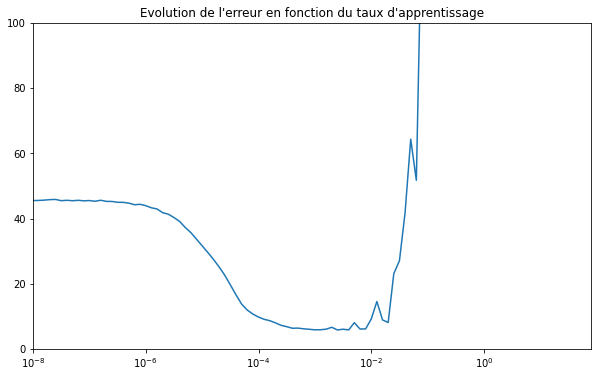

In [10]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [11]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [12]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
30/30 [==============================] - 3s 39ms/step - loss: 8.1915 - mae: 8.6824 - val_loss: 11.4379 - val_mae: 11.9268

Epoch 00001: val_loss improved from inf to 11.43795, saving model to poids.hdf5
Epoch 2/500
30/30 [==============================] - 1s 16ms/step - loss: 5.1379 - mae: 5.6207 - val_loss: 9.4629 - val_mae: 9.9570

Epoch 00002: val_loss improved from 11.43795 to 9.46290, saving model to poids.hdf5
Epoch 3/500
30/30 [==============================] - 1s 16ms/step - loss: 5.0402 - mae: 5.5206 - val_loss: 9.6533 - val_mae: 10.1477

Epoch 00003: val_loss did not improve from 9.46290
Epoch 4/500
30/30 [==============================] - 1s 15ms/step - loss: 4.8494 - mae: 5.3249 - val_loss: 7.3664 - val_mae: 7.8542

Epoch 00004: val_loss improved from 9.46290 to 7.36644, saving model to poids.hdf5
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 5.2112 - mae: 5.6871 - val_loss: 9.2366 - val_mae: 9.7291

Epoch 00005: val_loss did not impr

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

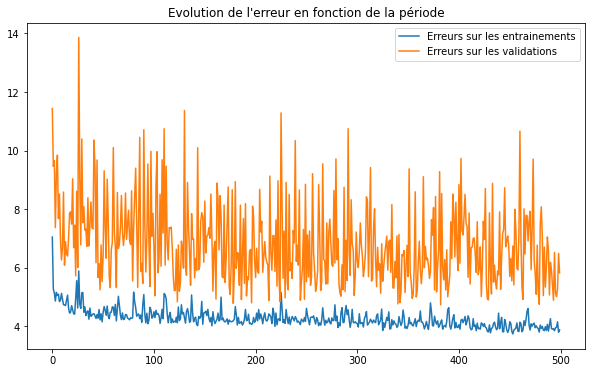

In [13]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

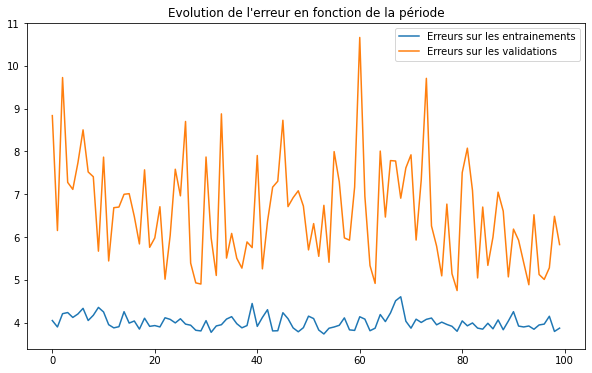

In [14]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [27]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [28]:

dataPredict = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

predictions = model.predict(dataPredict)
predictions = tf.reshape(predictions,shape=(predictions.shape[0]))

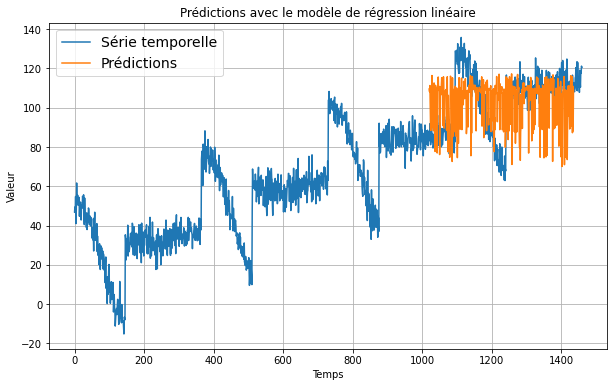

IndexError: ignored

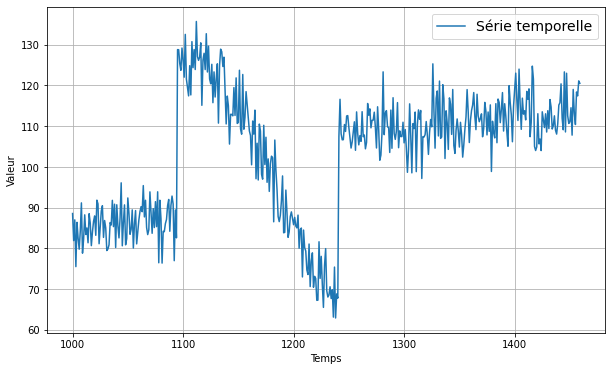

In [29]:
reste = len(temps[temps_separation+taille_fenetre:])-predictions.shape[0]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:-reste],np.asarray(predictions),label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

# Création de la série temporelle et du dataset pour l'entrainement

In [5]:
!wget "https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py"

--2021-03-16 21:33:14--  https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21419 (21K) [text/plain]
Saving to: ‘layers.py’

layers.py           100%[===================>]  20.92K  --.-KB/s    in 0.001s  

2021-03-16 21:33:14 (19.7 MB/s) - ‘layers.py’ saved [21419/21419]



In [8]:
from layers import SelfAttention

dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

X = tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size)
encoder_output, hidden_state = tf.keras.layers.GRU(dim_GRU,return_sequences=True, return_state=True)(tf.keras.layers.Lambda(Traitement_Entrees)(X))


encoder_output, attention_weights = SelfAttention(size=40,num_hops=6,use_penalization=False)(encoder_output)
Y = tf.keras.layers.Dense(units=1)(encoder_output)
encoder_output = tf.keras.layers.Lambda(Traitement_Sorties)(Y)

model = tf.keras.Model(inputs = X, outputs=encoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 20)]                0         
_________________________________________________________________
lambda_3 (Lambda)            (32, 20, 1)               0         
_________________________________________________________________
gru_2 (GRU)                  [(32, 20, 40), (32, 40)]  5160      
_________________________________________________________________
self_attention_2 (SelfAttent ((32, 240), (32, 6, 20))  1840      
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   241       
_________________________________________________________________
lambda_4 (Lambda)            (32, 1)                   0         
Total params: 7,241
Trainable params: 7,241
Non-trainable params: 0
_________________________________________________________

In [9]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
30/30 [==============================] - 2s 10ms/step - loss: 45.1033 - mae: 45.6022

Epoch 00001: loss improved from inf to 45.51350, saving model to poids.hdf5
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 45.1540 - mae: 45.6535

Epoch 00002: loss did not improve from 45.51350
Epoch 3/100
30/30 [==============================] - 0s 9ms/step - loss: 46.6131 - mae: 47.1126

Epoch 00003: loss did not improve from 45.51350
Epoch 4/100
30/30 [==============================] - 0s 9ms/step - loss: 44.7568 - mae: 45.2564

Epoch 00004: loss did not improve from 45.51350
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 46.5308 - mae: 47.0304

Epoch 00005: loss did not improve from 45.51350
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 44.4053 - mae: 44.9042

Epoch 00006: loss improved from 45.51350 to 45.47114, saving model to poids.hdf5
Epoch 7/100
30/30 [==============================] - 0s 9ms/step - l